In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
proj_dir = '/content/drive/MyDrive/cs410-final-project'
os.chdir(proj_dir)
!ls
original_path = os.getenv('PATH')

Mounted at /content/drive
document_information.csv  movies_document.csv		       testout
evaluation		  movies_inverted_index.csv	       unique_queries.csv
hadoop-3.3.0		  msrd				       unique_queries.txt
hadoop-3.3.0.tar.gz	  Readme.gdoc
imdb-search-engine	  semantic-search-for-beginners.ipynb


# Task 1: Data preprocessing


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('https://raw.githubusercontent.com/CourTeous33/imdb-search-engine/refs/heads/main/imdb_top_1000.csv')

# Create the document column by concatenating relevant fields
df['document'] = (
    df['Series_Title'] + ' ' +
    df['Overview'] + ' ' +
    df['Director'] + ' ' +
    df['Star1'] + ' ' +
    df['Star2'] + ' ' +
    df['Star3'] + ' ' +
    df['Star4'] + ' ' +
    df['Certificate'].astype(str) + ' ' +
    df['Released_Year'].astype(str)
)

# Drop duplicates based on Series_Title
df_unique = df.drop_duplicates(subset=['Series_Title'])

# Create final dataframe with required columns
dataset = pd.DataFrame({
    'index': np.arange(len(df_unique)),
    'movie_name': df_unique['Series_Title'],
    'document': df_unique['document']
})

# Save to CSV
dataset.to_csv('movies_document.csv', index=False)

In [ ]:
dataset[dataset["movie_name"] == "The Thing"]

,index,movie_name,document
271,270,The Thing,The Thing A research team in Antarctica is hun...


# Task 2 Build an inverted index

In [ ]:
!git clone https://github.com/CourTeous33/imdb-search-engine.git

Cloning into 'imdb-search-engine'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 18 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 447.35 KiB | 5.89 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Create Java home variable
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Download Hadoop
!wget https://archive.apache.org/dist/hadoop/common/hadoop-3.3.0/hadoop-3.3.0.tar.gz

--2024-12-09 00:37:43--  https://archive.apache.org/dist/hadoop/common/hadoop-3.3.0/hadoop-3.3.0.tar.gz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500749234 (478M) [application/x-gzip]
Saving to: ‘hadoop-3.3.0.tar.gz’

hadoop-3.3.0.tar.gz 100%[===================>] 477.55M  18.7MB/s    in 28s     

2024-12-09 00:38:11 (17.2 MB/s) - ‘hadoop-3.3.0.tar.gz’ saved [500749234/500749234]



In [ ]:
!tar -xzvf hadoop-3.3.0.tar.gz

Streaming output truncated to the last 5000 lines.
hadoop-3.3.0/share/doc/hadoop/hadoop-project-dist/hadoop-common/build/source/hadoop-common-project/hadoop-common/target/api/org/apache/hadoop/fs/FSDataOutputStream.html
hadoop-3.3.0/share/doc/hadoop/hadoop-project-dist/hadoop-common/build/source/hadoop-common-project/hadoop-common/target/api/org/apache/hadoop/fs/TrashPolicyDefault.Emptier.html
hadoop-3.3.0/share/doc/hadoop/hadoop-project-dist/hadoop-common/build/source/hadoop-common-project/hadoop-common/target/api/org/apache/hadoop/fs/HarFileSystem.html
hadoop-3.3.0/share/doc/hadoop/hadoop-project-dist/hadoop-common/build/source/hadoop-common-project/hadoop-common/target/api/org/apache/hadoop/fs/PathExistsException.html
hadoop-3.3.0/share/doc/hadoop/hadoop-project-dist/hadoop-common/build/source/hadoop-common-project/hadoop-common/target/api/org/apache/hadoop/fs/XAttrSetFlag.html
hadoop-3.3.0/share/doc/hadoop/hadoop-project-dist/hadoop-common/build/source/hadoop-common-project/hadoop-

In [ ]:
# Copy Hadoop directory to user/local
!cp -r hadoop-3.3.0/ /usr/local/

# Find the default Java path
!readlink -f /usr/bin/java | sed "s:bin/java::"

# Run Hadoop from /usr/local
!/usr/local/hadoop-3.3.0/bin/hadoop

# Create input folder (test example)
!mkdir ~/testin

# Copy example files to the input folder
!cp /usr/local/hadoop-3.3.0/etc/hadoop/*.xml ~/testin

# Check that files have been successfully copied (10 files should appear)
!ls ~/testin

# Remove the output folder to run Hadoop again
!rm -r ~/testout
# Run the mapreduce example (for sanity check)
!/usr/local/hadoop-3.3.0/bin/hadoop jar /usr/local/hadoop-3.3.0/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.0.jar \
    grep ~/testin ~/testout 'allowed[.]*'

/usr/lib/jvm/java-11-openjdk-amd64/
Usage: hadoop [OPTIONS] SUBCOMMAND [SUBCOMMAND OPTIONS]
 or    hadoop [OPTIONS] CLASSNAME [CLASSNAME OPTIONS]
  where CLASSNAME is a user-provided Java class

  OPTIONS is none or any of:

buildpaths                       attempt to add class files from build tree
--config dir                     Hadoop config directory
--debug                          turn on shell script debug mode
--help                           usage information
hostnames list[,of,host,names]   hosts to use in slave mode
hosts filename                   list of hosts to use in slave mode
loglevel level                   set the log4j level for this command
workers                          turn on worker mode

  SUBCOMMAND is one of:


    Admin Commands:

daemonlog     get/set the log level for each daemon

    Client Commands:

archive       create a Hadoop archive
checknative   check native Hadoop and compression libraries availability
classpath     prints the class path neede

In [ ]:
# # Remove the output folder to run Hadoop again
# !rm -r testout
# # Run hadoop to execute the mapper and reducer using the train.csv file
# !/usr/local/hadoop-3.3.0/bin/hadoop jar /usr/local/hadoop-3.3.0/share/hadoop/tools/lib/hadoop-streaming-3.3.0.jar \
#     -files /content/drive/MyDrive/cs410-final-project/imdb-search-engine/mapper.py,/content/drive/MyDrive/cs410-final-project/imdb-search-engine/reducer.py \
#     -input /content/drive/MyDrive/cs410-final-project/movies_document.csv \
#     -output /content/drive/MyDrive/cs410-final-project/testout \
#     -mapper "python3 mapper.py" \
#     -reducer "python3 reducer.py"

# Remove the output folder to run Hadoop again
!rm -r ~/testout
# Run hadoop to execute the mapper and reducer using the crawler.csv file
!/usr/local/hadoop-3.3.0/bin/hadoop jar /usr/local/hadoop-3.3.0/share/hadoop/tools/lib/hadoop-streaming-3.3.0.jar \
    -files /content/mapper.py -files /content/reducer.py \
    -input /content/movies_document.csv -output ~/testout \
    -mapper 'python mapper.py' -reducer 'python reducer.py'


2024-12-09 03:02:58,523 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2024-12-09 03:02:58,632 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2024-12-09 03:02:58,633 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2024-12-09 03:02:58,652 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2024-12-09 03:02:58,851 INFO mapred.FileInputFormat: Total input files to process : 1
2024-12-09 03:02:58,879 INFO mapreduce.JobSubmitter: number of splits:1
2024-12-09 03:02:59,094 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local835203133_0001
2024-12-09 03:02:59,094 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-12-09 03:02:59,442 INFO mapred.LocalDistributedCacheManager: Localized file:/content/mapper.py as file:/tmp/hadoop-root/mapred/local/job_local835203133_0001_f90281b4-685f-4eba-9f9c-a566a76e21ba/mapper.py
2024-12-09 03:02:59,611 INFO mapreduce.Job: The url to track 

### Inverted Index

In [ ]:
import pandas as pd

# Key is the word, value is hashMap, which store all docs that have the word, and how many times it appear in each doc
memo_vocab = {}
# Key is docId, value is the size of the doc
memo_doc = {}
# Key is word, value is how many times the word appears cross all collection
memo_pwc = {}

# with open('testout/part-00000', 'r') as file:
with open('/root/testout/part-00000', 'r') as file:
    for line in file:
      stripped_line = line.strip()
      split_line = stripped_line.split('\t', 2)
      # split_line: word, count_word_in_doc, doc_id
      current_word = split_line[0].strip()
      current_doc_frequency = int(split_line[1])
      current_doc_id = int(split_line[2])
      if current_word not in memo_vocab:
        memo_vocab[current_word] = {}
      memo_vocab[current_word][current_doc_id] = current_doc_frequency
      if current_word not in memo_pwc:
        memo_pwc[current_word] = 0
      memo_pwc[current_word] += current_doc_frequency
      if current_doc_id not in memo_doc:
        memo_doc[current_doc_id] = 0
      memo_doc[current_doc_id] += current_doc_frequency

vocab = []
for key, value in memo_pwc.items():
  vocab.append([key, value])
vocab = sorted(vocab, key=lambda x: x[1],reverse=True)

# Prepare word data for the DataFrame
rows = []
for word, total_count in vocab:
    # List of (doc_id, word_count) pairs for this word
    doc_list = [(doc_id, word_count) for doc_id, word_count in memo_vocab[word].items()]
    # Add to rows
    rows.append([word, total_count, doc_list])

# Create a DataFrame
df = pd.DataFrame(rows, columns=["Word", "Total Count", "Doc Details"])

# Save to CSV
output_csv_path = 'movies_inverted_index.csv'
df.to_csv(output_csv_path, index=False)

# Print the message
print(f"Inverted index saved to {output_csv_path}")

# Prepare document data for the DataFrame
rows = []
for docId, docLength in memo_doc.items():
  rows.append([docId, docLength])

# Create a DataFrame
df = pd.DataFrame(rows, columns=["Document_ID", "Document_Length"])

# Save to CSV
output_csv_path = 'document_information.csv'
df.to_csv(output_csv_path, index=False)

# Print the message
print(f"document_ids and their lengths are saved to {output_csv_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/root/testout/part-00000'

In [ ]:
df[df['Document_ID'] == 956]

,Document_ID,Document_Length
580,956,27


In [ ]:
import numpy as np
import pandas as pd
import ast
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

memo_vocab = {}
memo_doc = {}

def handle_inverted_index():
  # File Path to read the CSV
  inverted_index = "movies_inverted_index.csv"
  # Read the CSV file
  df = pd.read_csv(inverted_index)
  # Process each row (word)
  for index, row in df.iterrows():
    word = row["Word"]
    memo_vocab[word] = {}
    doc_details = row["Doc Details"]
    doc_details = ast.literal_eval(doc_details)
    for doc_id, count in doc_details:
      memo_vocab[word][doc_id] = count

def handle_document_information():
  # File Path to read the CSV
  document_information = "document_information.csv"
  # Read the CSV file
  df = pd.read_csv(document_information)
  # Process each row (word)
  for index, row in df.iterrows():
    doc_id = row["Document_ID"]
    doc_length = row["Document_Length"]
    memo_doc[doc_id] = doc_length

def adapt_voacb_query(queries):
  # Add query words into vocab
  vocab = set()
  for query in queries:
    words = query.split()
    for word in words:
      vocab.add(word)
  return vocab

def findAvdl(memo_doc):
  # return Avdl total number of words in collection / number of docs
  total_words = 0
  total_docs = len(memo_doc)
  for doc_id in memo_doc:
    total_words += memo_doc[doc_id]
  return total_words / total_docs

def BM25(query, memo_vocab, memo_doc, avdl):
  k = 3
  b = 0.65
  M = len(memo_doc)
  docs_score = {}
  for doc_id in memo_doc:
    docs_score[doc_id] = 0
  words = query.split()
  for word in words:
    word = stemmer.stem(word)
    if word in memo_vocab:
      dfw = len(memo_vocab[word])
      dinfo = memo_vocab[word]
      for doc_id in dinfo:
        d_word_count = dinfo[doc_id]
        d_len = memo_doc[doc_id]
        factor = 1-b+b*d_len/avdl
        if doc_id not in docs_score:
          docs_score[doc_id] = 0
        score = ((k+1) * d_word_count) / (d_word_count + k * factor)
        score = score * np.log((M+1)/dfw)
        docs_score[doc_id] += score
  return docs_score

if __name__ == "__main__":
    queries = ["Mulan", "murder", "Man"]

    # Process the inverted index and document information
    handle_inverted_index()
    handle_document_information()

    # Adapt vocabulary for queries
    vocab = adapt_voacb_query(queries)
    avdl = findAvdl(memo_doc)

    # Read the movie document file
    with open("movies_document.csv", 'r') as file:
        lines = file.readlines()

    # Run queries and calculate BM25 scores
    for query in queries:
        result = BM25(query, memo_vocab, memo_doc, avdl)

        # Sort the results based on scores in descending order
        sorted_result = sorted(result.items(), key=lambda item: item[1], reverse=True)

        # Extract top and bottom 5 results
        top_first_5 = sorted_result[:5]
        top_last_5 = sorted_result[-5:]

        # Print top 5 results
        print(f"Query: {query} - Top 5 documents")
        for doc_id, score in top_first_5:
            # Get the corresponding line from the CSV file
            line = lines[doc_id-1]  # Adjust for 0-based indexing
            movie_name = line.split(',')[1]
            print(f"Movie: {movie_name}, Score: {score}")

        print()

Query: Mulan - Top 5 documents
Movie: Mulan, Score: 10.113153065186038
Movie: Coraline, Score: 0
Movie: The Exorcist, Score: 0
Movie: The Revenant, Score: 0
Movie: Barry Lyndon, Score: 0

Query: murder - Top 5 documents
Movie: Anatomy of a Murder, Score: 7.397497771037224
Movie: Dead Man, Score: 4.86753693113189
Movie: Sholay, Score: 4.635931575252822
Movie: Peeping Tom, Score: 4.635931575252822
Movie: Primal Fear, Score: 4.425365460035269

Query: Man - Top 5 documents
Movie: Dead Man, Score: 5.285571397816188
Movie: Edward Scissorhands, Score: 3.7997554319895723
Movie: Man on Fire, Score: 3.7997554319895723
Movie: Inside Man, Score: 3.7997554319895723
Movie: The Elephant Man, Score: 3.7691708520728278



In [ ]:
#Ollie
import numpy as np
import pandas as pd
import ast
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

class BM25Searcher:
    def __init__(self,
                 inverted_index_path="movies_inverted_index.csv",
                 document_information_path="document_information.csv",
                 document_path="movies_document.csv",
                 k=3, b=0.65):
        self.inverted_index_path = inverted_index_path
        self.document_information_path = document_information_path
        self.document_path = document_path
        self.k = k
        self.b = b

        self.memo_vocab = {}
        self.memo_doc = {}
        self.doc_id_to_data = {}

        self._load_data()

    def _load_data(self):
        # Load inverted index
        inverted_df = pd.read_csv(self.inverted_index_path)
        for index, row in inverted_df.iterrows():
            word = row["Word"]
            self.memo_vocab[word] = {}
            doc_details = row["Doc Details"]
            doc_details = ast.literal_eval(doc_details)
            for doc_id, count in doc_details:
                self.memo_vocab[word][doc_id] = count

        # Load document information
        doc_info_df = pd.read_csv(self.document_information_path)
        for index, row in doc_info_df.iterrows():
            doc_id = row["Document_ID"]
            doc_length = row["Document_Length"]
            self.memo_doc[doc_id] = doc_length

        # Load original documents
        with open(self.document_path, 'r') as file:
            lines = file.readlines()
            for i, line in enumerate(lines, start=1):
                parts = line.strip().split(',')
                if len(parts) > 1:
                    movie_name = parts[1]
                else:
                    movie_name = "Unknown"
                description = ','.join(parts[2:]) if len(parts) > 2 else ""
                self.doc_id_to_data[i] = {
                    'movie_name': movie_name,
                    'description': description
                }

        # Precompute average document length
        self.avdl = self._find_avdl()

    def _find_avdl(self):
        total_words = sum(self.memo_doc.values())
        total_docs = len(self.memo_doc)
        return total_words / total_docs

    def _bm25_score(self, query):
        M = len(self.memo_doc)
        docs_score = {doc_id: 0 for doc_id in self.memo_doc}
        words = query.split()
        for word in words:
            word = stemmer.stem(word)
            if word in self.memo_vocab:
                dfw = len(self.memo_vocab[word])
                dinfo = self.memo_vocab[word]
                for doc_id in dinfo:
                    d_word_count = dinfo[doc_id]
                    d_len = self.memo_doc[doc_id]
                    factor = 1 - self.b + self.b * (d_len / self.avdl)
                    score = ((self.k + 1) * d_word_count) / (d_word_count + self.k * factor)
                    score *= np.log((M + 1) / dfw)
                    docs_score[doc_id] += score
        return docs_score

    def search(self, queries, top_k=10):
        # queries: a list of query strings
        # top_k: number of top results to return per query
        all_results = []
        for query in queries:
            doc_scores = self._bm25_score(query)
            sorted_result = sorted(doc_scores.items(), key=lambda item: item[1], reverse=True)

            results = []
            for doc_id, score in sorted_result[:top_k]:
                movie_name = self.doc_id_to_data[doc_id]['movie_name']
                description = self.doc_id_to_data[doc_id]['description']
                results.append({
                    'movie': movie_name,
                    'score': score,
                    'description': description
                })

            all_results.append({'results': results})

        return all_results
bm25_searcher = BM25Searcher(
    inverted_index_path="movies_inverted_index.csv",
    document_information_path="document_information.csv",
    document_path="movies_document.csv",
    k=3, b=0.65
)
query = 'superhero action adventure'
bm25_results = bm25_searcher.search([query], top_k=5)[0]['results']
for result in bm25_results:
    print(f"Movie: {result['movie']}, Score: {result['score']}")

Movie: Watchmen, Score: 8.508969221189906
Movie: The Incredibles, Score: 8.508969221189906
Movie: Birdman or (The Unexpected Virtue of Ignorance), Score: 5.989334129060827
Movie: Kick-Ass, Score: 5.390730204127102
Movie: Coraline, Score: 5.382407925153657


# Task 3 W2V similarity ranking


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
class MovieSearchSystem:
    def __init__(self, df, document_column='document', title_column='movie_name'):
        """
        Initialize the search system with a pandas DataFrame

        Parameters:
        df (pandas.DataFrame): DataFrame containing movie information
        document_column (str): Name of the column containing the text to analyze
        title_column (str): Name of the column containing movie titles
        """
        # Store DataFrame and column names
        self.df = df
        self.document_column = document_column
        self.title_column = title_column

        # Initialize NLP tools
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Preprocess documents
        self.processed_docs = [self.preprocess_text(doc) for doc in self.df[document_column]]

        # Train Word2Vec model
        self.model = Word2Vec(sentences=self.processed_docs,
                            vector_size=100,
                            window=5,
                            min_count=1,
                            workers=4)

        # Calculate document vectors
        self.doc_vectors = self.calculate_doc_vectors()

    def preprocess_text(self, text):
        # Convert to lowercase
        text = str(text).lower()

        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return tokens

    def calculate_doc_vectors(self):
        doc_vectors = []
        for doc in self.processed_docs:
            vector = np.zeros(self.model.vector_size)
            count = 0
            for word in doc:
                if word in self.model.wv:
                    vector += self.model.wv[word]
                    count += 1
            if count > 0:
                vector /= count
            doc_vectors.append(vector)
        return np.array(doc_vectors)

    def search(self, query, num_results=5):
        # Preprocess query
        processed_query = self.preprocess_text(query)

        # Calculate query vector
        query_vector = np.zeros(self.model.vector_size)
        count = 0
        for word in processed_query:
            if word in self.model.wv:
                query_vector += self.model.wv[word]
                count += 1
        if count > 0:
            query_vector /= count

        # Handle zero vector case
        if np.all(query_vector == 0):
            return []

        # Calculate cosine similarity
        similarities = np.dot(self.doc_vectors, query_vector) / (
            np.linalg.norm(self.doc_vectors, axis=1) * np.linalg.norm(query_vector)
        )

        # Get top results
        top_indices = np.argsort(similarities)[-num_results:][::-1]

        results = []
        for idx in top_indices:
            results.append({
                'movie_title': self.df.iloc[idx][self.title_column],
                'similarity_score': similarities[idx]
            })

        return results

# Example usage
if __name__ == "__main__":
    # Load data from CSV (example)
    df = pd.read_csv('movies_document.csv')

    # Initialize the search system with DataFrame
    search_system = MovieSearchSystem(df)

    # Example searches
    test_queries = [
        "superhero action adventure",
        "romantic comedy love",
        "crime thriller detective",
        "science fiction space",
        "war historical drama",
        "2004"
    ]

    for query in test_queries:
        print(f"\nSearch Query: {query}")
        results = search_system.search(query)
        print("Top 5 Results:")
        for i, result in enumerate(results, 1):
            print(f"{i}. {result['movie_title']} (Similarity: {result['similarity_score']:.4f})")

# Task 4: Movie Ranking System


In [ ]:
class MovieRankingSystem:
    def __init__(self, bm25_searcher, semantic_searcher, df, document_column='document', title_column='movie_name', bm25_weight=0.3):
        self.bm25_searcher = bm25_searcher
        self.semantic_searcher = semantic_searcher
        self.bm25_weight = bm25_weight
        self.df = df
        self.document_column = document_column
        self.title_column = title_column
        self.title_to_doc = dict(zip(df[title_column], df[document_column]))


    def normalize_scores(self, scores):
        min_score = min(scores)
        max_score = max(scores)
        if max_score == min_score:
            return [1.0] * len(scores)
        return [(s - min_score) / (max_score - min_score) for s in scores]

    def search(self, query, top_k=10, show_detailed_scores=False):
        bm25_results = self.bm25_searcher.search([query], top_k=1000)[0]['results']
        bm25_scores = {r['movie']: r['score'] for r in bm25_results}
        movie_descriptions = {r['movie']: r.get('description', '') for r in bm25_results}

        semantic_results = self.semantic_searcher.search(query, num_results=1000)
        semantic_scores = {r['movie_title']: r['similarity_score'] for r in semantic_results}

        all_movies = set(bm25_scores.keys()) | set(semantic_scores.keys())

        all_bm25_scores = [bm25_scores.get(movie, 0) for movie in all_movies]
        all_semantic_scores = [semantic_scores.get(movie, 0) for movie in all_movies]

        normalized_bm25 = dict(zip(all_movies, self.normalize_scores(all_bm25_scores)))
        normalized_semantic = dict(zip(all_movies, self.normalize_scores(all_semantic_scores)))

        movie_scores = []
        for movie in all_movies:
            combined_score = (
                self.bm25_weight * normalized_bm25[movie] +
                (1 - self.bm25_weight) * normalized_semantic.get(movie, 0)
            )

            if show_detailed_scores:
                result = {
                    'title': movie,
                    'movie_description': self.title_to_doc.get(movie, ''),
                    'combined_score': combined_score,
                    'original_bm25': bm25_scores.get(movie, 0),
                    'original_semantic': semantic_scores.get(movie, 0),
                    'normalized_bm25': normalized_bm25[movie],
                    'normalized_semantic': normalized_semantic.get(movie, 0)
                }
            else:
                result = {
                    'title': movie,
                    'movie_description': self.title_to_doc.get(movie, ''),
                    'score': combined_score
                }

            movie_scores.append(result)

        return sorted(movie_scores, key=lambda x: x.get('combined_score' if show_detailed_scores else 'score'), reverse=True)[:top_k]



In [ ]:
bm25_searcher = BM25Searcher(
    inverted_index_path="movies_inverted_index.csv",
    document_information_path="document_information.csv",
    document_path="movies_document.csv",
    k=3, b=0.65
)
df = pd.read_csv('movies_document.csv')
semantic_searcher = MovieSearchSystem(df)

In [ ]:
ranking_system = MovieRankingSystem(bm25_searcher, semantic_searcher, df, document_column='document', title_column='movie_name')
results = ranking_system.search("mulan", show_detailed_scores=True)
results

[{'title': 'Mulan',
  'movie_description': "Mulan To save her father from death in the army, a young maiden secretly goes in his place and becomes one of China's greatest heroines in the process. Tony Bancroft Barry Cook Ming-Na Wen Eddie Murphy BD Wong U 1998",
  'combined_score': 1.0,
  'original_bm25': 10.113153065186038,
  'original_semantic': 0.4084155583824646,
  'normalized_bm25': 1.0,
  'normalized_semantic': 1.0},
 {'title': 'Udaan',
  'movie_description': 'Udaan Expelled from his school, a 16-year old boy returns home to his abusive and oppressive father. Vikramaditya Motwane Rajat Barmecha Ronit Roy Manjot Singh Ram Kapoor UA 2010',
  'combined_score': 0.6173722926241219,
  'original_bm25': 0,
  'original_semantic': 0.3407844173980817,
  'normalized_bm25': 0.0,
  'normalized_semantic': 0.8819604180344599},
 {'title': 'Festen',
  'movie_description': "Festen At Helge's 60th birthday party, some unpleasant family truths are revealed. Thomas Vinterberg Ulrich Thomsen Henning Mo

In [ ]:
results = ranking_system.search("superhero action adventure", show_detailed_scores=True)  # detailed output
results

[{'title': 'Kick-Ass',
  'movie_description': 'Kick-Ass Dave Lizewski is an unnoticed high school student and comic book fan who one day decides to become a superhero, even though he has no powers, training or meaningful reason to do so. Matthew Vaughn Aaron Taylor-Johnson Nicolas Cage Chloë Grace Moretz Garrett M. Brown UA 2010',
  'combined_score': 0.8900605137001514,
  'original_bm25': 5.390730204127102,
  'original_semantic': 0.2588386466401277,
  'normalized_bm25': 0.6335350456671713,
  'normalized_semantic': 1.0},
 {'title': 'Life of Pi',
  'movie_description': 'Life of Pi A young man who survives a disaster at sea is hurtled into an epic journey of adventure and discovery. While cast away, he forms an unexpected connection with another survivor: a fearsome Bengal tiger. Ang Lee Suraj Sharma Irrfan Khan Adil Hussain Tabu U 2012',
  'combined_score': 0.7695452204868528,
  'original_bm25': 5.011418622721105,
  'original_semantic': 0.17349626620561195,
  'normalized_bm25': 0.5889571

# Task 5 Evaluation


In [ ]:
def extract_queries(path='evaluation/movie_queries_101.csv', save_path='evaluation/unique_queries_101.csv'):
    """
    Extract unique queries from MSRD dataset
    """
    queries_df = pd.read_csv(path, sep='\t')
    print(queries_df.head())
    unique_queries = queries_df['query'].unique()
    unique_queries = unique_queries[:101]
    pd.DataFrame(unique_queries, columns=['query']).to_csv(save_path, index=False)
    return unique_queries, len(unique_queries)

# Usage
queries, count = extract_queries()
print(f"Extracted {count} unique queries")
print("\nSample queries:")
print(queries[:3])

                    query
0     action movies 2000s
1     prison escape films
2         mob crime drama
3        war movies 1990s
4  psychological thriller
Extracted 101 unique queries

Sample queries:
['action movies 2000s' 'prison escape films' 'mob crime drama']


In [ ]:
# Loading all queries for our search engine
def process_queries(ranking_system, queries_path='evaluation/unique_queries_101.csv', results_path='evaluation/predictions_101.csv'):
    queries = pd.read_csv(queries_path)['query'].tolist()
    all_results = []

    for i, query in enumerate(queries):
        try:
            results = ranking_system.search(query, show_detailed_scores=True)
            for result in results:
                all_results.append({
                    'query': query,
                    'title': result['title'],
                    'description': result['movie_description'],
                    'combined_score': result['combined_score'],
                    'bm25_score': result['original_bm25'],
                    'semantic_score': result['original_semantic']
                })

        except Exception as e:
            print(f"Error processing query '{query}': {str(e)}")
            continue

    pd.DataFrame(all_results).to_csv(results_path, index=False)
    return all_results
# Example usage:
sample_results = process_queries(ranking_system)
print(f"Processed {len(sample_results)} results")

Processed 1010 results


In [ ]:
import json
import csv
from collections import defaultdict

class Evaluator:
    def __init__(self, ground_truth_file, predictions_file, movie_list_file):
        # movie_list_file: a file containing the 1000 available movies in JSON format
        self.all_movies = self._load_all_movies(movie_list_file)
        self.ground_truth = {}
        self.predictions = {}

        self._load_ground_truth(ground_truth_file)
        self._load_predictions(predictions_file)

    def _load_all_movies(self, movie_list_file):
        print("Step 0: Loading all available movies from file...")
        with open(movie_list_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        valid_movie_names = {item['movie_name'].strip() for item in data}
        print(f"Loaded {len(valid_movie_names)} valid movie names.")
        return valid_movie_names

    def _load_ground_truth(self, ground_truth_file):
        print("Step 1: Loading ground truth from file...")
        with open(ground_truth_file, 'r', encoding='utf-8') as f:
            data = f.read().strip()

        try:
            gt_data = json.loads(data)
            # If it's a single dict, wrap it in a list
            if isinstance(gt_data, dict):
                gt_data = [gt_data]
        except json.JSONDecodeError:
            print("Ground truth file is not a proper JSON array. Trying line-by-line parsing.")
            gt_data = []
            for line in data.split('\n'):
                line = line.strip()
                if line:
                    gt_data.append(json.loads(line))

        print("Step 2: Filtering ground truth movies based on available 1000 movies...")
        modified_count = 0
        removed_queries = 0

        # Variables to track filtering stats
        total_original_movies = 0
        total_filtered_movies = 0

        for item in gt_data:
            query = item["query"]
            movie_list = [r["movie"].strip() for r in item["rankings"]]
            filtered_movie_list = [m for m in movie_list if m in self.all_movies]

            original_count = len(movie_list)
            filtered_count = len(filtered_movie_list)
            total_original_movies += original_count
            total_filtered_movies += filtered_count

            if filtered_count < original_count:
                # Ground truth modified for this query
                modified_count += 1

            if filtered_movie_list:
                self.ground_truth[query] = filtered_movie_list
            else:
                # If no movies remain after filtering, we do not store this query
                removed_queries += 1

        retained_queries = len(self.ground_truth)
        total_queries = len(gt_data)

        print(f"Loaded filtered ground truth for {retained_queries} queries out of {total_queries} total.")
        print(f"{modified_count} queries had their ground truth modified.")
        print(f"{removed_queries} queries were removed entirely because none of their movies matched.")

        # Calculate average number of filtered-out movies per query
        # total filtered out = total_original_movies - total_filtered_movies
        # We divide by total_queries (original count before filtering)
        if total_queries > 0:
            avg_filtered_out = (total_original_movies - total_filtered_movies) / total_queries
        else:
            avg_filtered_out = 0.0

        print(f"Average number of filtered-out movies per query: {avg_filtered_out:.2f}")

    def _load_predictions(self, predictions_file):
        print("Step 3: Loading predictions from CSV...")
        pred_dict = defaultdict(list)
        with open(predictions_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                q = row["query"].strip()
                title = row["title"].strip()
                if len(pred_dict[q]) < 10:
                    pred_dict[q].append(title)

        self.predictions = dict(pred_dict)
        print(f"Loaded predictions for {len(self.predictions)} queries.")

    def evaluate(self):
        print("Step 4: Evaluating metrics...")
        precisions = []
        recalls = []
        f1s = []

        common_queries = set(self.ground_truth.keys()) & set(self.predictions.keys())
        print(f"Number of queries to evaluate: {len(common_queries)}")

        for q in common_queries:
            gt = self.ground_truth[q]
            pred = self.predictions[q]

            hits = sum(1 for p in pred if p in gt)

            precision = hits / len(pred) if pred else 0.0
            recall = hits / len(gt) if gt else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

            # print("----")
            # print(f"Query: {q}")
            # print(f"Ground Truth: {gt}")
            # print(f"Predictions: {pred}")
            # print(f"Hits: {hits}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        avg_precision = sum(precisions)/len(precisions) if precisions else 0.0
        avg_recall = sum(recalls)/len(recalls) if recalls else 0.0
        avg_f1 = sum(f1s)/len(f1s) if f1s else 0.0

        print("----")
        print("Step 5: Final evaluation results (basic hit criteria):")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1: {avg_f1:.4f}")


# Example usage (not part of the class, just demonstration):
evaluator = Evaluator("evaluation/ground_truth_101.json", "evaluation/predictions_101.csv","evaluation/movies_json.json")
evaluator.evaluate()


Step 0: Loading all available movies from file...
Loaded 999 valid movie names.
Step 1: Loading ground truth from file...
Step 2: Filtering ground truth movies based on available 1000 movies...
Loaded filtered ground truth for 107 queries out of 108 total.
92 queries had their ground truth modified.
1 queries were removed entirely because none of their movies matched.
Average number of filtered-out movies per query: 3.49
Step 3: Loading predictions from CSV...
Loaded predictions for 101 queries.
Step 4: Evaluating metrics...
Number of queries to evaluate: 99
----
Step 5: Final evaluation results (basic hit criteria):
Average Precision: 0.0394
Average Recall: 0.0638
Average F1: 0.0465


Step 0: Loading all available movies from file...
Loaded 999 valid movie names.
Step 1: Loading ground truth from file...
Step 2: Filtering ground truth movies based on available 1000 movies...
Loaded filtered ground truth for 107 queries out of 108 total.
92 queries had their ground truth modified.
1 queries were removed entirely because none of their movies matched.
Average number of filtered-out movies per query: 3.49
Step 3: Loading predictions from CSV...
Loaded predictions for 101 queries.
BM25 Weight: 0.1
**Average Precision**: 0.0293
**Average Recall**: 0.0457
**Average F1**: 0.0343
----
Step 0: Loading all available movies from file...
Loaded 999 valid movie names.
Step 1: Loading ground truth from file...
Step 2: Filtering ground truth movies based on available 1000 movies...
Loaded filtered ground truth for 107 queries out of 108 total.
92 queries had their ground truth modified.
1 queries were removed entirely because none of their movies matched.
Average number of filtered

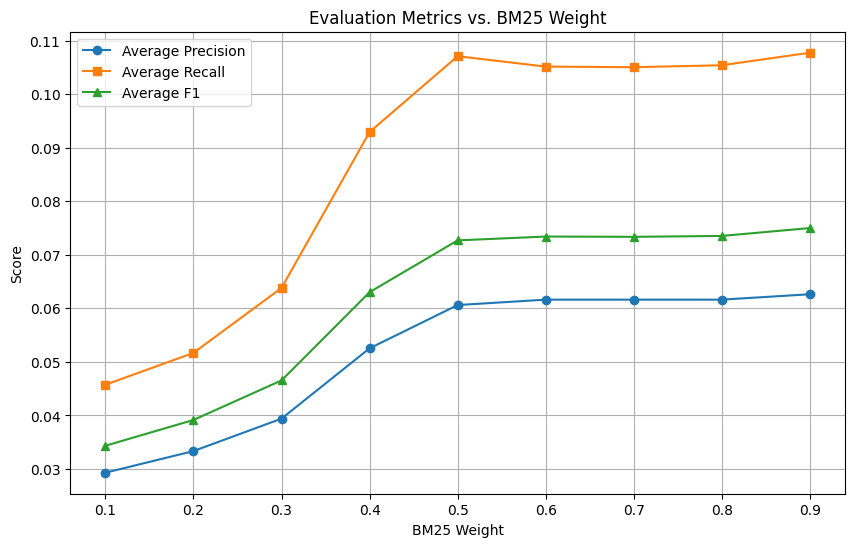

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bm25_weights = np.arange(0.1, 1.0, 0.1)
avg_precisions = []
avg_recalls = []
avg_f1s = []

for w in bm25_weights:
    ranking_system = MovieRankingSystem(
        bm25_searcher=bm25_searcher,
        semantic_searcher=semantic_searcher,
        df=df,
        bm25_weight=w
    )

    results = process_queries(ranking_system,
                              queries_path=f'evaluation/unique_queries_101.csv',
                              results_path=f'evaluation/predictions_101_bm25_{w}.csv')


    evaluator = Evaluator(
        ground_truth_file="evaluation/ground_truth_101.json",
        predictions_file=f"evaluation/predictions_101_bm25_{w}.csv",
        movie_list_file="evaluation/movies_json.json"
    )

    precisions = []
    recalls = []
    f1_scores = []
    common_queries = set(evaluator.ground_truth.keys()) & set(evaluator.predictions.keys())
    for q in common_queries:
        gt = evaluator.ground_truth[q]
        pred = evaluator.predictions[q]

        hits = sum(1 for p in pred if p in gt)
        precision = hits / len(pred) if pred else 0.0
        recall = hits / len(gt) if gt else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    avg_precision = sum(precisions)/len(precisions) if precisions else 0.0
    avg_recall = sum(recalls)/len(recalls) if recalls else 0.0
    avg_f1 = sum(f1_scores)/len(f1_scores) if f1_scores else 0.0

    avg_precisions.append(avg_precision)
    avg_recalls.append(avg_recall)
    avg_f1s.append(avg_f1)

    print(f"BM25 Weight: {w:.1f}")
    print(f"**Average Precision**: {avg_precision:.4f}")
    print(f"**Average Recall**: {avg_recall:.4f}")
    print(f"**Average F1**: {avg_f1:.4f}")
    print("----")

plt.figure(figsize=(10, 6))
plt.plot(bm25_weights, avg_precisions, marker='o', label='Average Precision')
plt.plot(bm25_weights, avg_recalls, marker='s', label='Average Recall')
plt.plot(bm25_weights, avg_f1s, marker='^', label='Average F1')
plt.xlabel('BM25 Weight')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. BM25 Weight')
plt.grid(True)
plt.legend()
plt.show()
